In [470]:
import pytesseract
from pytesseract import Output
import re
import glob
import numpy as np
import cv2
from PIL import Image #testando
import imutils #testando
from collections import namedtuple #testando
from skimage import filters
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,7) #apresenta todas as imagens na proporção definida

## Função que lê imagens, aplica image_to_data e retorna as keys

In [471]:
def data_keys(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    return d

## Função para extrair datas

In [472]:
def get_datas(img, d):
    date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$' # expressão regular para datas
    data_nasc, data_val, data_ph = 0, 0, 0
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40 and int(d['left'][i]) > 80 and int(d['top'][i]) > 80:
            #print(d['text'][i])
            if re.match(date_pattern, d['text'][i]):
                #print(d['text'][i])
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                if int(d['top'][i]) >= 150 and int(d['top'][i]) <= 250:
                    data_nasc = d['text'][i]
                elif int(d['left'][i]) >= 290 and int(d['left'][i]) <= 400:
                    data_val = d['text'][i]
                elif int(d['left'][i]) >= 400 and int(d['left'][i]) <= 600:
                    data_ph = d['text'][i]
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.show()
    
    return data_nasc, data_val, data_ph

## Função para extrair CPF

In [473]:
def get_cpf(img, d):
    #cpf_pattern = '[0-9]{3}\.?[0-9]{3}\.?[0-9]{3}\-?[0-9]{2}'

    cpf_expr = re.compile('\d{3}\.\d{3}\.\d{3}\-\d{2}')
    #cpf_expr1 = re.compile('\d{3}\.\d{3}')
    #cpf_expr2 = re.compile('\d{3}\?\d{2}')                     

    cpf = 0
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40:
            if re.match(cpf_expr, d['text'][i]):
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cpf = d['text'][i]
                
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return cpf

## Desenha boxes

In [474]:
def drawboxes(img, d):
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        #if int(d['conf'][i]) > 40:
        if int(d['left'][i]) > 60 and int(d['top'][i]) > 95:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img

## Corta Nome

In [475]:
def crop_name(img):
    imgcrop = img[5:5+45, 5:5+490] # para as alinhadas: img[100:100+40, 90:90+490]
    return imgcrop

## Limpa texto

In [476]:
#limpa caracteres não ASCII
def cleanup_text(text):
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [477]:
# imgs = glob.glob("../processadas/*jpg")

# for c in imgs:
    
#     img = cv2.imread(c)

#     cropped = crop_name(img)
  
#     plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
#     plt.show()

#     text = pytesseract.image_to_string(cropped, lang='por')
    
#     text1 = cleanup_text(text)
#     print(text1)

# TESTES DE SEGMENTAÇÃO

In [478]:
def crop_name_seg(img):
    imgcrop = img[100:100+40, 90:90+490] 
    return imgcrop

In [479]:
def cannyedges(img):
    edges = cv2.Canny(img,80,150)
    return edges

In [480]:
def dilatacao(img):
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    return dilation

In [481]:
def erosao(img):
    kernel = np.ones((2,2),np.uint8)
    erosion = cv2.erode(img,kernel)
    return erosion

In [482]:
def opening(img):
    kernel = np.ones((2,2),np.uint8)
    op = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return op

In [483]:
def gaussianBlurring(img):
    blur1 = cv2.GaussianBlur(img, (5, 5), 0)
    return blur1

In [484]:
def conv_edges(img):
    convolution_matrix = np.array([[0,1,0],
                                  [1,-4,1],
                                  [0,1,0]]) #filtro/matriz para detecção de bordas
    edg = cv2.filter2D(img, -1, convolution_matrix)
    return edg

In [485]:
def sharpenFunction(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) #matriz de convolução que aplica nitidez
    return cv2.filter2D(image, -1, kernel)

In [486]:
def inverte(img):
    ret,thresh1 = cv2.threshold(img,87,255,cv2.THRESH_BINARY)
    #ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    return thresh1

In [487]:
def settozero(img):
    ret, thresh = cv2.threshold(img, 170, 255, cv2.THRESH_TOZERO)
    return thresh

In [488]:
def thresholding(image):
    (T,Thresh1) = cv2.threshold(image, 185, 255, cv2.THRESH_TRUNC)#Valores maiores do que o limite são ajustados iguais ao valor do limite e os valores menores do que o limite permanecem inalterados.
    (T,Thresh3) = cv2.threshold(Thresh1, 43, 255, cv2.THRESH_BINARY)#transforma qualquer valor acima do limite em valor mínimo possível e qualquer valor abaixo do limite em valor máximo possível.
    (T,Thresh2) = cv2.threshold(Thresh3, 0 ,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)#o valor limite no pixel (x, y) é a soma ponderada gaussiana dos valores de vizinhança menos alguma constante C.
    (T,Thresh4) = cv2.threshold(Thresh2, 30, 255, cv2.CALIB_CB_ADAPTIVE_THRESH)
    return Thresh3

In [489]:
def togray(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return g

In [490]:
def filterFunction(image):
    (T,Thresh1) = cv2.threshold(image, 200, 255, cv2.THRESH_TRUNC)
    Thresh2 = cv2.adaptiveThreshold(Thresh1, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 231,50)
    return Thresh2

In [491]:
def bilateral(img):
    bil = cv2.bilateralFilter(img, 11, 77, 77) #3, 21, 21 #5, 35, 35 #7, 49, 49 #9, 63, 63 #11, 77, 77
    return bil

In [492]:
def thresholdLocal(img):
    T = skimage.filters.threshold_local(img, 11, offset = 10, method = "gaussian")
    imag = (gray > T).astype("uint8") * 255
    return imag

In [493]:
def cleanImage(image, stage = 0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # aplicando as operações topHat/blackHat
    topHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel) #revela as áreas claras com fundo escuro
    blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel) #revela as áreas escuras com um fundo claro
    # fazendo adição e subtração entre as operações morfológicas
    add = cv2.add(gray, topHat)
    subtract = cv2.subtract(add, blackHat)
    if (stage == 1):
        return subtract
    T = skimage.filters.threshold_local(subtract, 29, offset=7, method="gaussian", mode="mirror")
    thresh = (subtract > T).astype("uint8") * 255
    if (stage == 2):
        return thresh
    # inverte a imagem 
    thresh = cv2.bitwise_not(thresh)
    return thresh

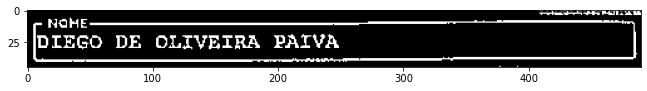

mm
DIEGO DE. OLIVEIRA PAIVA


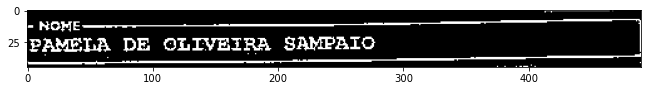

.NDHE__fW
EAMELA DE OLIVEIRA SAMPAIO
___f


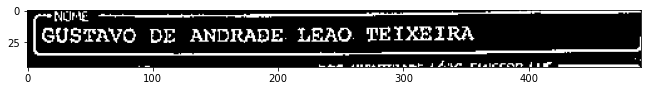

NLM: ___-___
GUSTAVO DE ANDRADE LEAO TEIXEIRA


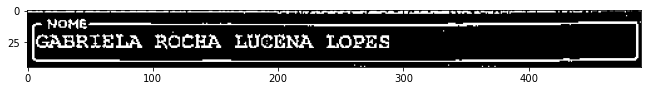

Nana
GABRIELA ROCHA LUCENA mpzs


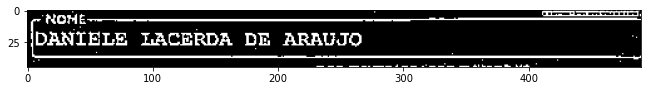

nuns
DANIELE LACERDA DE ARAUJO


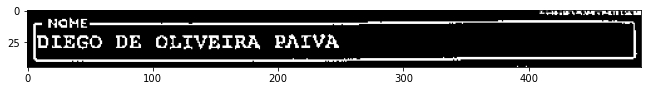

mm
DIEGO DE. OLIVEIRA PAIVA


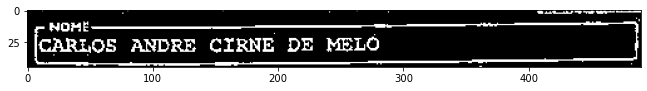

mm;
cmos ANDRE CIRNE DE MELO
1560 DE OLIVEIRA PAIVA


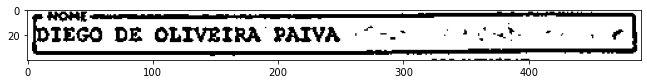

w
nuam DE OLIVEIRA amino


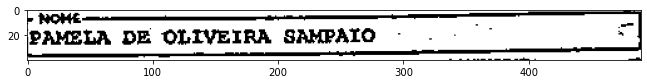

GUSTAVO DE ANDRADE LEAO TEIXEIRA


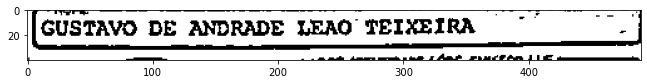

m
GABRIELA ROCHA LUCENA mms


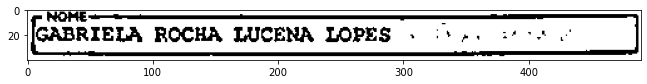

num

DANIELE LACERDA DE. mmo


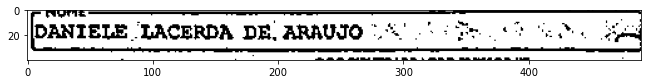

1560 DE OLIVEIRA PAIVA


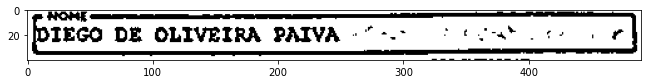

m
CARLOS ANDRE CIRNE DE MELO


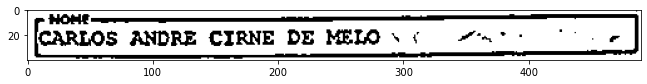

In [497]:
images = glob.glob("../alinhadas/*jpg")
images2 = glob.glob("../processadas/*jpg")

for n in images2:
        
    image = cv2.imread(n)
    cropped = crop_name(image)
    clean = cleanImage(cropped)
    plt.imshow(cv2.cvtColor(clean, cv2.COLOR_BGR2RGB))
    plt.show()
    
    text = pytesseract.image_to_string(clean, lang='por')
    text1 = cleanup_text(text)
    print(text1)


for j in images:

    image = cv2.imread(j)
    croppedn = crop_name_seg(image)
    clean = cleanImage(croppedn, 2)
    binar = inverte(clean)

    text = pytesseract.image_to_string(clean, lang='por')
    text1 = cleanup_text(text)
    print(text1)
    
    plt.imshow(cv2.cvtColor(clean, cv2.COLOR_BGR2RGB))
    plt.show()


In [495]:
# imgs = glob.glob("../processadas/*jpg")

# for c in imgs:
#     img = cv2.imread(c)
#     d = data_keys(img)
#     img = drawboxes(img, d)
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
# #     data_nasc, data_val, data_ph = get_datas(img, d)
# #     cpf = get_cpf(img, d)
# #     print("CPF: ", cpf)
# #     print("Data de nascimento: ", data_nasc)
# #     print("Data de validade: ", data_val)
# #     print("Data da 1° habilitação: ", data_ph)

Próximos passos:

- melhorar segmentação das imagens, a leitura está péssima

-validar o cpf
https://community.alteryx.com/t5/Casos-de-uso-Portugues/Validacao-de-CPF-com-digito-verificador/ta-p/437296

OBS.: o regex cpf_pattern está reconhecendo o número de registro e não o cpf